## 1. $H\rightarrow b\bar{b}$ via Machine Learning 

Machine learning algorithms are one of the ways with which we create Artificial Intelligence. The distinguishing featuere of machine learning compared to usual programming is training. Instead of programming the steps to get to the solution to a problem we program a machine learning algorithm to be trained to learn the steps towards the desired solution. 

On the ATLAS $H\rightarrow b\bar{b}$ analysis, using machine learning allows us to extract information about the correlations between the different kinematic variables to improve discrimination between signal and background. 

In this exercise you will build and train a Neural Network algorithm to classify $H\rightarrow b\bar{b}$ events instead of using sequential cuts. 

### 1.1 What is a Neural Network?

The neural network model is loosely based on the human brain. A Neuron receives a number of input signals, these signals are then processed at the neuron which passes on a new signal (fires) to the next neuron only if a certain condition is met. 

A neural network is a collection of artificial neurons organised in layers (as shown in the image below) that connect together allowing the neural network to learn complexities and make sophisticated decisions. The artificial neurons work by simple multiplication between the input signals (variables) coming into the node and a set of weights. If the produce of this multiplication is above a certain threshold, the neuron fires! 


![Neural Network](https://i.stack.imgur.com/OH3gI.png)

The neurons must be trained to process the signal appropriately so as to maximise the accuracy in decision making. To understand this, let's go back to the human brain analogy. Say you were teaching your younger sibling how to recognise numbers. You would repeatedly show them pictures of numbers and tell them which one is which. You might test their knowledge by giving them a new image and then seeing whether they recognised what digit it was. You might then praise them for getting it right and correct them if they got it wrong. 


Neurons are trained in a similar way. To train a neural network to learn how to recognise handwritten digits we would give it thousands of images of labelled handwritten digits. It will pass these images through the network in the form of numbers between 0 and 1, compute the product between these inputs (the image in the form of numbers) and the weights at all neurons. The final product at the end of the  neural network will be used to reach a decision. The training process updates the weights such that the accuracy is maximised. 

This process is similar to maximisation (or minimisation) problems you may have done in A-Level Maths using differentiation to find the minimum/maximum value of function. 

All this might sound a bit confusing! Don’t worry it is a lot to take in within a short space of time. Ask your mentors about anything you’re unsure about. 

We're now going to learn how to build and apply a neural network in Python using the Keras library. 


### 1.2 Neural Networks in Keras

The algorithm for doing the $H\rightarrow b\bar{b}$ can be summarised with the following 6 steps:

* Import libraries and load data.
* Build neural network. 
* Training Neural Network. 
* Make decisions about events using the Neural Network. 
* Calculate sensitivity. 


### Importing libraries and loading 

The Keras library is a free open-source tool to quickly and easily develop with neural networks. It does a lot of the heavy lifting for us making it an ideal tool for prototyping. Just like any popular Python library, it is well documented with guides explaining how to use it. These are available here: https://keras.io/

In this exercise, your mentors will guide you through a lot of the code that has already been written for you so that you can focus specifically on building the neural network. It is still valuable to understand what is going on so make sure you ask questions! 

In [1]:
# Download the data files if we need them. If you download the repo as a ZIP, 
# this cell is not needed. If running on colab, it will automatically download
# all required data.

from pathlib import Path

data_path = Path('../data-v1/VHbb_data_2jet.csv')
class_path = Path('ucl_masterclass.py')
if not data_path.exists():
    !wget -P ../data-v1/ https://raw.githubusercontent.com/nikitapond/in2HEP/master/data-v1/VHbb_data_2jet.csv 
else:
    print("Data file already found")
if not class_path.exists():
    !wget https://raw.githubusercontent.com/nikitapond/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")

Data file already found
Required custom classes already found


In [2]:
import pandas as pd
from copy import deepcopy
from ucl_masterclass import *
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_yaml
from keras.layers import Input, Dense, Dropout, Flatten
from keras import backend as K
from sklearn.model_selection import train_test_split
from time import time

### Loading in the data

In [3]:
df= pd.read_csv(data_path)


train_split = 0.7
val_split = 0.15
test_split = 0.15

# Scale up the event weight. This ensures when evaluating, that we have the equivilent
# of a full dataset. This prevents lower sensitivity caused by using a lower number of 
# evaluation events.
df['EventWeight'] /= test_split


df_train, df_test = train_test_split(df, test_size=1-train_split)
df_test, df_val = train_test_split(df_test, test_size=test_split/(test_split+val_split))


### Data preparation

As dicussed in lectures, ML models perform better if the data passed to them has all variables are of similar scale. There are a few ways to do this. Some of the most popular are:
- Min max scaling: Scale all our data so values are between 0 and 1
- Standard scaling: Calculate the mean and standard deviation (std) of each variable, then take $v' = (v - \mu)/\sigma$ Where $\mu$ and $\sigma$ are the mean and std respectedly.
- Normalisation: Scale so all values are between -1 and 1

Below, we use the 'minmax' scaler with the predefined function. You can also try 'norm' and 'standard'.

The function below returns 5 total variables. They are:
- x_train: The training inputs for the model
- y_train: The training labels
- w_train: The training weights (TODO)
- dset_val: A tuple of the form (x_val, y_val) that containing data for validation. We return it as a tuple, as this is the easiest way to pass it in model.fit
- dset_test: TODO

In [4]:
variables = ['dRBB','mBB','MET','Mtop','pTV',]

(x_train, y_train, w_train, 
 dset_val, dset_test) = scale_prepare_data(df_train, df_val, df_test, variables, scaler='minmax')
    
    

### Training 

The neural network is given a set of training events that have a Class label of 1 for signal and 0 for background. During the training phase, the neural network goal is to *learn* how to map input variables given to it (kinematic and topological quantities of the event) to 0 for background and 1 for signal. 

To ensure that the neural network is learning general features about the signal and background process and not just **artifacts** unique to the training data set, we split the data set into a training, validation, and testing set. We train on the train data, and evaluate each epoch on the validation data, to see how the model is training. We then finally evaluate on the testing dataset, to ensure we haven't over optimised for the training/validation set.

**In the section below we extract the input (x) and target values (y) used to train the neural network.**

### Building a Neural Network

To build the neural network we will be using the Keras *Sequential* model. This works by allowing us to add layers into our model using the following line of code which adds a layer with 10 neurons. 
```python
model.add(Dense(units=10,activation='relu')) # adds a layer with 10 neurons. 
```

By sequentially adding layers you can create a fully connected deep neural network within minutes! 


**Ask your mentor to explain what the following terms are:**
* Activiation
* Loss
* Gradient Descent 



### Task
Earlier you developed an analysis for $H\rightarrow b\bar{b}$ using sequential cuts on 'dRBB','mBB','MET','Mtop', and'pTV'. You will now build a neural network to classify the simulated events as signal or background. 

After discussing neural network architectures with your mentor you will: 

* In the code cell below, define the architecture for your neural network. 
* Set the batch size used in training and the number of epochs in training. 

Once you have done this run the code to start training your neural network. The time taken to train the network will be printed at the end. 

In [5]:
def classifier(variables):
    """
    Creates a model for higgs to bb classification
    
    returns: Keras model
    """
    num_variables = len(variables)

    model = Sequential()
    
    # The input layer
    model.add(Dense(units=num_variables,input_dim = num_variables,activation='relu'))
    
    # Add hidden layers here
    # ======================
    model.add(Dense(units=10,activation='relu'))
    model.add(Dense(units=10,activation='relu'))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [6]:
# TESTING

senses = []
for i in range(20):
        
    # Create and compile model
    model = classifier(variables)

    # Set these parameters
    # ====================
    epochs = 5
    batchSize = 64
    # train
    history = model.fit(x_train, y_train, sample_weight = w_train,
            validation_data = dset_val, 
            epochs=epochs, batch_size=batchSize,verbose = 1)
    df_test['decision_value'] = model.predict(dset_test[0])
    s = sensitivity_NN(df_test)[0]
        # print("A sensitivity of", round(sensitivity_NN(df_test)[0],2),'was achieved')
        # nn_output_plot(df_test)
    senses.append(s)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:

start = time()

# Create and compile model
model = classifier(variables)

# Set these parameters
# ====================
epochs = 5
batchSize = 64
# train
history = model.fit(x_train, y_train, sample_weight = w_train,
          validation_data = dset_val, 
          epochs=epochs, batch_size=batchSize,verbose = 1)

print("model trained in " + str(round(time()-start,2))+"s")

Epoch 1/5
1290/1290 [==============================] - 3s 2ms/step - loss: 0.6545 - accuracy: 0.6226 - val_loss: 0.6371 - val_accuracy: 0.6387
Epoch 2/5
1290/1290 [==============================] - 2s 1ms/step - loss: 0.6037 - accuracy: 0.6842 - val_loss: 0.6036 - val_accuracy: 0.7097
Epoch 3/5
1290/1290 [==============================] - 2s 1ms/step - loss: 0.5609 - accuracy: 0.7203 - val_loss: 0.5828 - val_accuracy: 0.7183
Epoch 4/5
1290/1290 [==============================] - 2s 1ms/step - loss: 0.5347 - accuracy: 0.7269 - val_loss: 0.5735 - val_accuracy: 0.7224
Epoch 5/5
1290/1290 [==============================] - 2s 2ms/step - loss: 0.5204 - accuracy: 0.7301 - val_loss: 0.5675 - val_accuracy: 0.7255
model trained in 28.6s


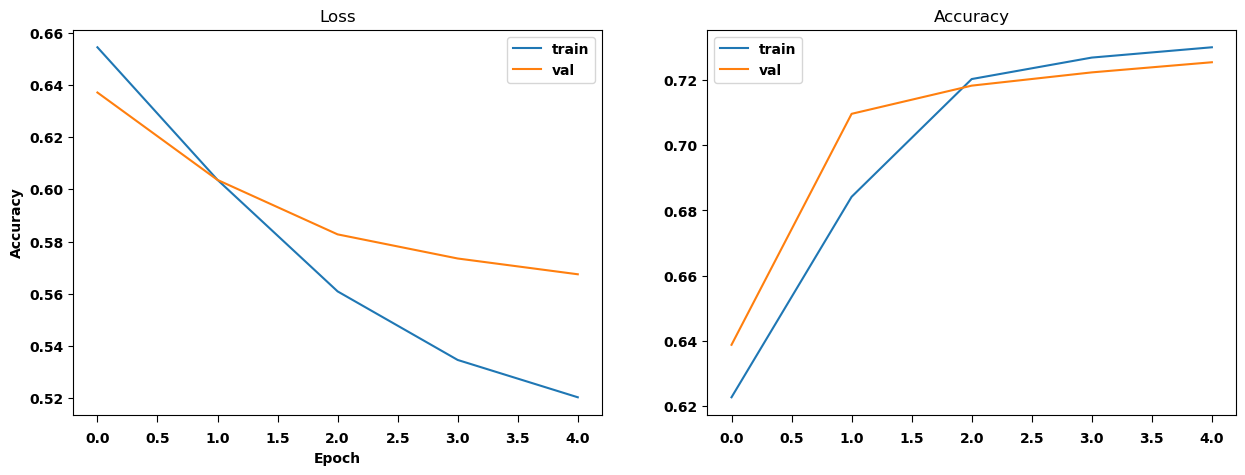

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].set_title("Loss")
ax[0].set_ylabel("Binary Cross Entropy Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='val')
ax[1].set_title("Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[1].legend()

### Evaluating our Neural Network

The code below will now test your neural networks on unseen events. Remember if a neural network was trained on the odd data set and hence it will be tested on the even data set. The neural network is used to classify the events and calculate the sensitivity using the neural network scores plotted in the histogram below.



TrafoD 21
A sensitivity of 1.08 was achieved


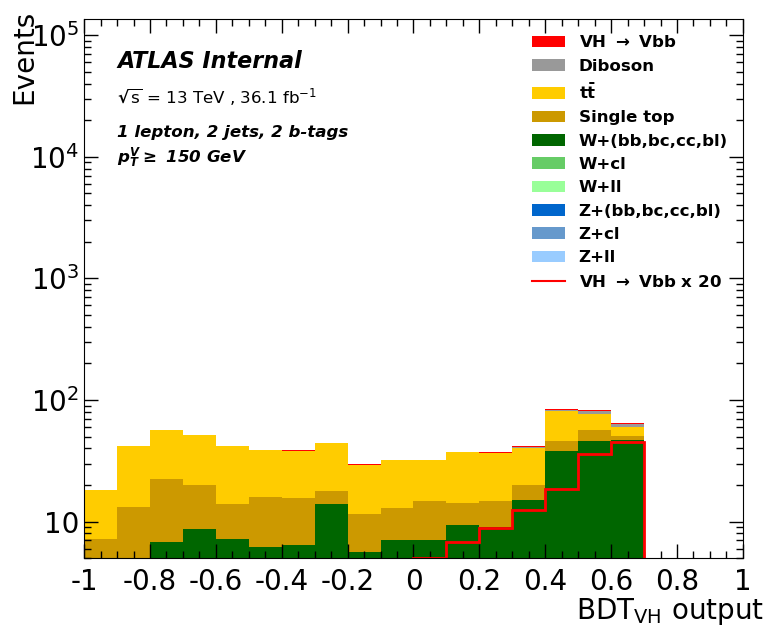

(<Figure size 850x700 with 1 Axes>,
 <AxesSubplot:xlabel='BDT$_{VH}$ output', ylabel='Events'>)

In [16]:
df_test['decision_value'] = model.predict(dset_test[0])
print("A sensitivity of", round(sensitivity_NN(df_test)[0],2),'was achieved')
nn_output_plot(df_test)

### Exercises:

* Build and evaluate a neural network with 3 'hidden' layers.
* Vary the number of epochs and the batch_size. 

Note down the sensitivity achieved and the time taken in training.


### Challenge
In your groups, you will now prototype your own neural network architecture. At the end of the event judges will be a prize for the group with best neural network based on the following criteria: 
* Sensitivity achieved.
* Time taken in training. 
* Elegance of architecture. (used in tie break situations) 

You can change any of the parameters in the function above. 

In [ ]:
start = time()
num_variables = len(variables)

# Define architecture 
def classifier():
    """
    Creates a model for higgs to bb classification
    
    returns: Keras model
    """
    
    model = Sequential()
    
    # The input layer
    model.add(Dense(units=num_variables,input_dim = num_variables,activation='relu'))
    
    # Add hidden layers here
    # ======================
    
    
    
    
    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model


# Create and compile models
model_even = classifier()
model_odd = classifier()


# Set these parameters
# ====================
epochs = 
batchSize = 


# train
model_even.fit(x_even,y_even,sample_weight = w_even, epochs=epochs, batch_size=batchSize,verbose = 1)
model_odd.fit(x_odd,y_odd,sample_weight = w_odd, epochs=epochs, batch_size=batchSize,verbose = 1)

print("model trained in " + str(round(time()-start,2))+"s")

In [ ]:
## Evaluation Code
df_odd['decision_value'] = model_even.predict_proba(x_odd)
df_even['decision_value'] = model_odd.predict_proba(x_even)
df = pd.concat([df_odd,df_even])
print("A sensitivity of", round(sensitivity_NN(df)[0],2),'was achieved')
nn_output_plot(df)

## Summary 

Neural Networks can learn correlations between variables and create a better understanding of the classification process hence leading to better signal sensitivity. They have been very popular in industry and regularly win competitions on the Kaggle machine learning forum. If you are interested in doing more machine learning this is a free 'nanodegree' on deep learning: https://www.youtube.com/watch?v=vOppzHpvTiQ&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3

**This material was produced by hackingEducation**  
<img src="images/logo-black.png" width="50" align = 'left'/>
